In [5]:
!pip install seaborn

<Figure size 2400x2000 with 0 Axes>

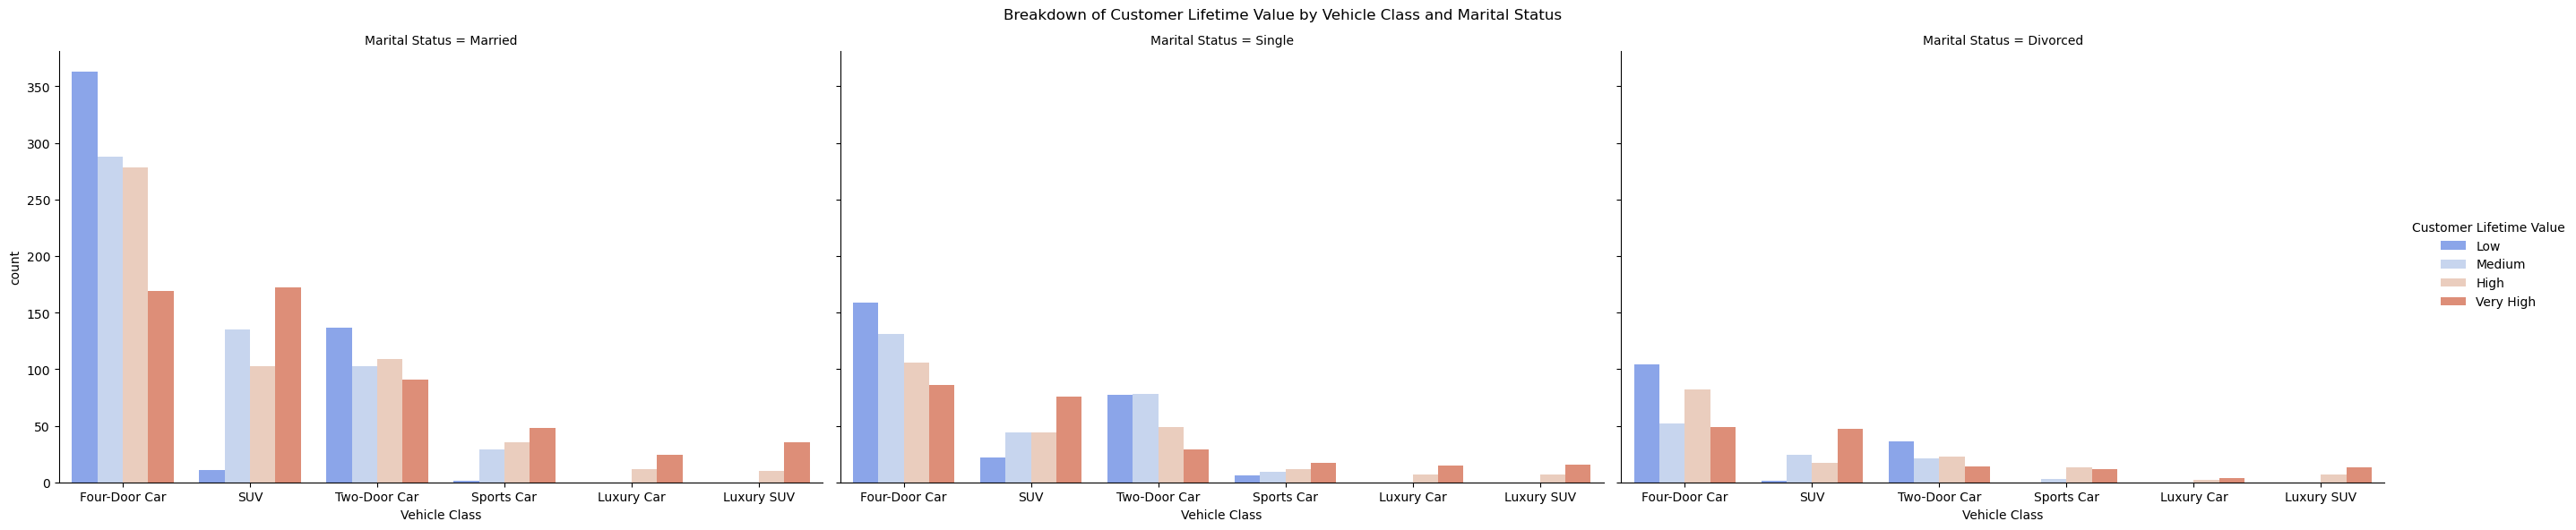

In [9]:
import seaborn as sns

facet_data = data.copy()
facet_data['Customer Lifetime Value'] = pd.qcut(
    facet_data['Customer Lifetime Value'], 4, labels=['Low', 'Medium', 'High', 'Very High']
)

# multi-faceted plot
plt.figure(figsize=(24, 20))
sns.catplot(
    data=facet_data,
    x='Vehicle Class',
    hue='Customer Lifetime Value',
    col='Marital Status',
    kind='count',
    height=6,
    aspect=1.5,
    palette='coolwarm'
)
plt.subplots_adjust(top=0.9)
plt.suptitle('Breakdown of Customer Lifetime Value by Vehicle Class and Marital Status')
plt.show()

In [10]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2f79cd19-de81-48ae-aae5-fba9107879f6;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 210ms :: artifacts dl 7ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------

3.4.0


In [13]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Insurance Data Analysis") \
    .getOrCreate()

# Read the CSV file with semicolon delimiter
df_spark = spark.read \
    .option("delimiter", ";") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('../../data/cleaned_data/external_data_cleaned.csv')

# Show the schema and first few rows
df_spark.printSchema()
df_spark.show(5)

root
 |-- "","Customer","State","Customer Lifetime Value","Response","Coverage","Coverage Index","Education","Education Index","Effective To Date","Employment Status","Employment Status Index","Gender","Income","Location","Location Index","Marital Status","Marital Status Index","Monthly Premium Auto","Months Since Last Claim","Months Since Policy Inception","Number of Open Complaints","Number of Policies","Policy Type","Policy Type Index","Policy","Policy Index","Renew Offer Type","Sales Channel","Sales Channel Index","Total Claim Amount","Vehicle Class","Vehicle Class Index","Vehicle Size","Vehicle Size Index": string (nullable = true)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count

spark = SparkSession.builder.appName("SummaryTable").getOrCreate()

data_path = "../../data/cleaned_data/external_data_cleaned.csv"  # Replace with the correct path
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(data_path)

df.printSchema()

summary_table = (
    df.groupBy("Marital Status")
    .agg(
        avg("Monthly Premium Auto").alias("avg_premium"),
        count("Customer").alias("number_of_customers"),
        avg("Total Claim Amount").alias("avg_claim_amount"),
        avg("Income").alias("avg_income")
    )
    .orderBy("Marital Status")
)

summary_table.show()

root
 |-- _c0: integer (nullable = true)
 |-- Customer: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Customer Lifetime Value: double (nullable = true)
 |-- Response: string (nullable = true)
 |-- Coverage: string (nullable = true)
 |-- Coverage Index: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Education Index: integer (nullable = true)
 |-- Effective To Date: string (nullable = true)
 |-- Employment Status: string (nullable = true)
 |-- Employment Status Index: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Location Index: integer (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Marital Status Index: integer (nullable = true)
 |-- Monthly Premium Auto: integer (nullable = true)
 |-- Months Since Last Claim: integer (nullable = true)
 |-- Months Since Policy Inception: integer (nullable = true)
 |-- Number of Open Com

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("TotalClaimAmountByState").getOrCreate()

data_path = "../../data/cleaned_data/external_data_cleaned.csv"
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(data_path)

total_claims_by_state = (
    df.groupBy("State")
    .agg(
        F.sum("Total Claim Amount").alias("total_claim_amount")
    )
    .orderBy("State")
)

total_claims_by_state.show()

24/12/10 05:16:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+----------+------------------+
|     State|total_claim_amount|
+----------+------------------+
|   Arizona|414801.25000000006|
|California| 739033.1200000007|
|    Nevada|193150.09999999995|
|    Oregon| 580152.1700000012|
|Washington|205650.90999999995|
+----------+------------------+



<Figure size 1000x1500 with 0 Axes>

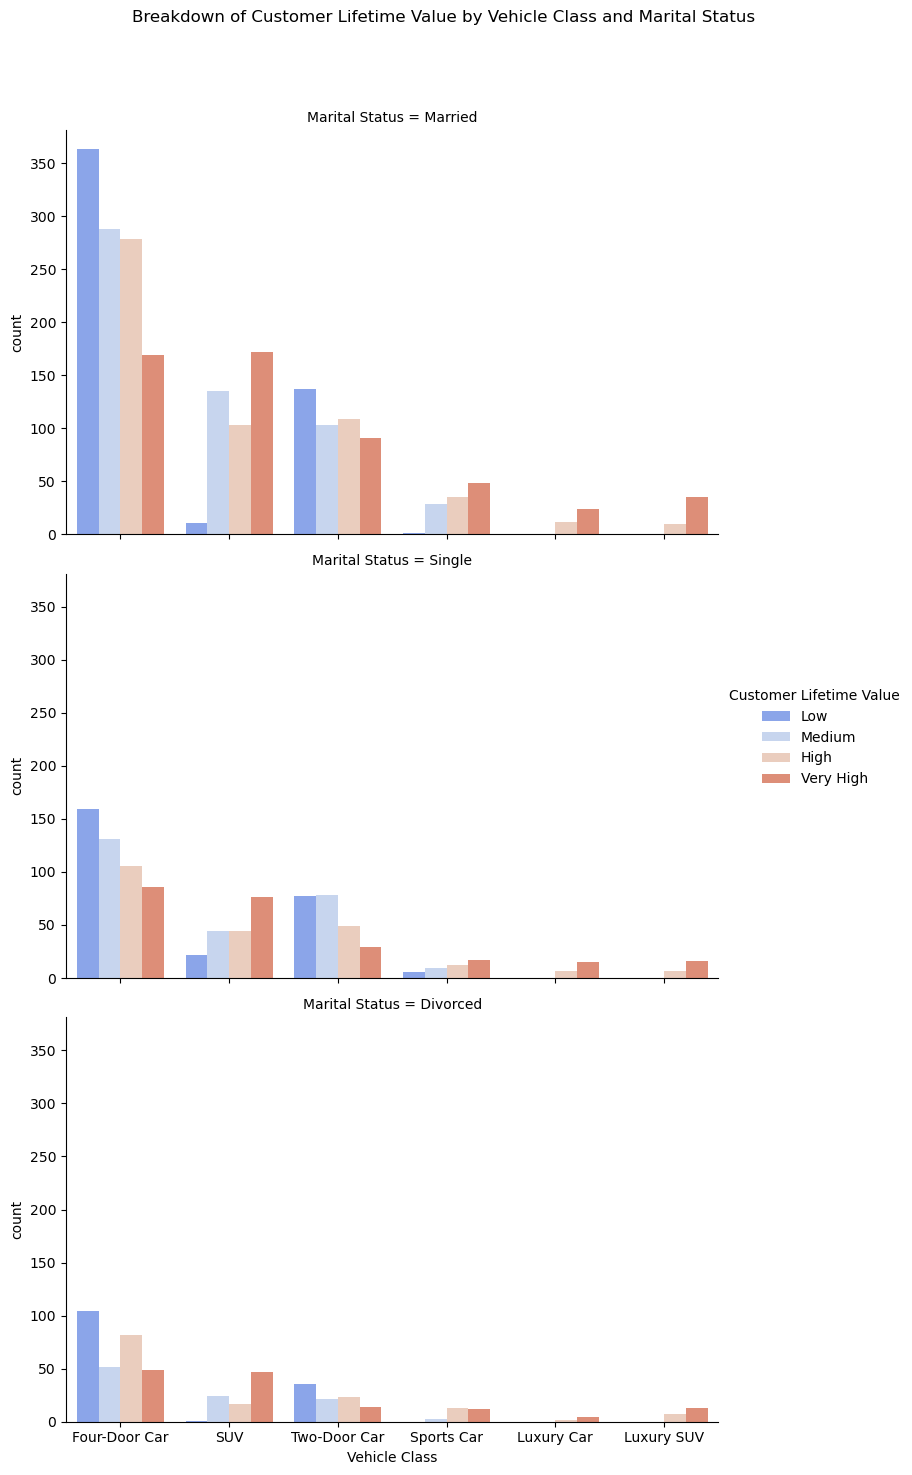

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

facet_data = data.copy()

facet_data['Customer Lifetime Value'] = pd.qcut(
    facet_data['Customer Lifetime Value'], 4, labels=['Low', 'Medium', 'High', 'Very High']
)

plt.figure(figsize=(10, 15))
sns.catplot(
    data=facet_data,
    x='Vehicle Class',
    hue='Customer Lifetime Value',
    col='Marital Status',
    kind='count',
    col_wrap=1,
    height=5,
    aspect=1.5,
    palette='coolwarm'
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Breakdown of Customer Lifetime Value by Vehicle Class and Marital Status')
plt.show()